<a href="https://colab.research.google.com/github/arpitsg/NTU_Decentralized_Federated/blob/main/Mnist_Fed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install np_utils


     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-cp37-none-any.whl size=57133 sha256=50c5e3d8f4f22beefcc14d69558fef528f28787db4e1b97072e9cc2da24badfa
  Stored in directory: /root/.cache/pip/wheels/92/4b/81/206efd0d01330a96f3aebe5021d2d5f0b264b7ade827c306ef
Successfully built np-utils


In [ ]:
 
import numpy as np
import random
import cv2
import os
from tensorflow.keras.datasets import mnist
from keras.utils.np_utils import to_categorical

from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K



def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
     
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
   
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels


def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    
    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}



def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


class SimpleMLP:
    @staticmethod
    def build(shape, classes,only_digits=True):
        # add Convolutional layers
        model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Reshape((28,28,1),input_shape = (784,)),
        tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(28,28,1)), #26
        tf.keras.layers.Conv2D(16, 3, activation='relu'), #24
        tf.keras.layers.Conv2D(32, 3, activation='relu'), #22
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #11
        tf.keras.layers.Conv2D(8,1,activation='relu'), 
        tf.keras.layers.Conv2D(16, 3, activation='relu'), #9
        tf.keras.layers.Conv2D(32, 3, activation='relu'), #7
        tf.keras.layers.Conv2D(32, 1, activation='relu'), #7
        tf.keras.layers.Conv2D(10, 7),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Activation('softmax')])

        # compile with adam optimizer & categorical_crossentropy loss function
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model
 
    

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(1 * weight[i])
    return weight
def scale_model_weights2(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(1 * weight[i])
    return weight_final


def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad
def test_model_mid(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    return acc, loss

def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('acc: {:.3%} | loss: {}'.format(acc, loss))
    return acc, loss


In [ ]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


# #declear path to your mnist data folder
# img_path = '/content/drive/MyDrive/archive'

# #get the path list using the path object
# image_paths = list(paths.list_images(img_path))

# #apply our function
# image_list, label_list = load(image_paths)






In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28, 28, 1))

X_test = X_test.astype('float32') / 255
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [ ]:
X_test.shape

(10000, 784)

In [ ]:
#reate clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

    


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from matplotlib import pyplot as plt
for i in range(10):
    img = X_test[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

In [ ]:
y_test[2]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#create optimizer
comms_round = 10
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

average_weights=global_model.get_weights()
average_weights = np.array(average_weights)

average_weights.fill(0)

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    average_weights = np.array(average_weights)

    average_weights.fill(0)
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()
    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_model.get_weights())
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=10, verbose=0)
      
        weights=local_model.get_weights();
        weights = np.array(weights)
        average_weights=np.add(average_weights,weights)
        K.clear_session()
    average_weights=average_weights/10
    average_weights = average_weights.tolist()


    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


acc: 96.540% | loss: 1.5070016384124756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


acc: 97.450% | loss: 1.4935691356658936
acc: 97.620% | loss: 1.4902969598770142
acc: 97.780% | loss: 1.4887511730194092
acc: 97.880% | loss: 1.4876700639724731
acc: 97.980% | loss: 1.4870253801345825
acc: 98.030% | loss: 1.4864264726638794
acc: 98.070% | loss: 1.485959768295288
acc: 98.090% | loss: 1.485711932182312
acc: 98.130% | loss: 1.4854093790054321


In [ ]:
97.8

In [ ]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(32)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(784, 10) 

SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=100, verbose=0)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)


comm_round: 1 | global_acc: 98.210% | global_loss: 1.4844398498535156


In [ ]:

    
#individual

#initial list to collect local model weights after scalling
scaled_local_weight_list = list()

#randomize client data - using keys
client_names= list(clients_batched.keys())

AVG_ACC=0;
#loop through each client and create new local model
for client in client_names:
    print(client)
    smlp_local = SimpleMLP()
    local_model = smlp_local.build(784, 10)
    local_model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=metrics)
    
    
    
    #fit local model with client's data
    local_model.fit(clients_batched[client], epochs=100, verbose=0)

    for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, local_model, 1)
        AVG_ACC+=SGD_acc;




    
    #clear session to free memory after each communication round
    K.clear_session()
    
print(AVG_ACC)

client_1
comm_round: 1 | global_acc: 22.540% | global_loss: 2.2983672618865967
client_2
comm_round: 1 | global_acc: 16.260% | global_loss: 2.3010098934173584
client_3
comm_round: 1 | global_acc: 86.980% | global_loss: 1.6527448892593384
client_4
comm_round: 1 | global_acc: 86.670% | global_loss: 1.6739091873168945
client_5
comm_round: 1 | global_acc: 62.430% | global_loss: 2.171509265899658
client_6
comm_round: 1 | global_acc: 89.960% | global_loss: 1.6097965240478516
client_7
comm_round: 1 | global_acc: 86.790% | global_loss: 1.65725839138031
client_8
comm_round: 1 | global_acc: 79.840% | global_loss: 1.7898120880126953
client_9
comm_round: 1 | global_acc: 27.730% | global_loss: 2.3002676963806152
client_10
comm_round: 1 | global_acc: 87.700% | global_loss: 1.6474820375442505
6.469


In [ ]:
#ranking
comms_round = 10
    
#create optimizer
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)
ranking_acc_comp=list() 
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    
    ranking_acc=list()
    ranking_acc.clear()
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
 
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        for(X_test, Y_test) in test_batched:
         local_acc, local_loss = test_model(X_test, Y_test, local_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
        ranking_acc.append(local_acc)
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    ranking_acc.sort(reverse=True)
    temp=0
    avg=0
    for i in range(comm_round+1):
      avg+=ranking_acc[i]
    avg=avg/(comm_round+1)
    ranking_acc_comp.append(avg)
  



    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


comm_round: 0 | global_acc: 90.110% | global_loss: 1.6017265319824219
comm_round: 0 | global_acc: 88.010% | global_loss: 1.6028382778167725
comm_round: 0 | global_acc: 87.950% | global_loss: 1.6463390588760376
comm_round: 0 | global_acc: 88.560% | global_loss: 1.642466425895691
comm_round: 0 | global_acc: 86.790% | global_loss: 1.6584093570709229
comm_round: 0 | global_acc: 84.620% | global_loss: 1.6909700632095337
comm_round: 0 | global_acc: 84.280% | global_loss: 1.6429452896118164
comm_round: 0 | global_acc: 82.580% | global_loss: 1.719176173210144
comm_round: 0 | global_acc: 80.580% | global_loss: 1.7435277700424194
comm_round: 0 | global_acc: 82.880% | global_loss: 1.727699637413025
comm_round: 0 | global_acc: 89.330% | global_loss: 1.6308485269546509
comm_round: 1 | global_acc: 93.130% | global_loss: 1.5605180263519287
comm_round: 1 | global_acc: 93.530% | global_loss: 1.5669422149658203
comm_round: 1 | global_acc: 93.590% | global_loss: 1.5560367107391357
comm_round: 1 | global_

In [ ]:
print(ranking_acc_comp)

[0.9011, 0.93775, 0.9521666666666667, 0.9592499999999999, 0.96164, 0.9645, 0.9657428571428571, 0.9675625, 0.9679777777777778, 0.9684399999999999]


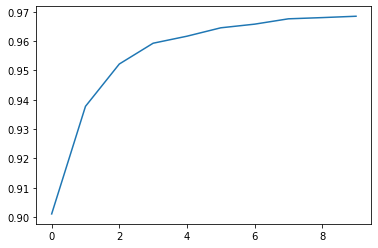

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ranking_acc_comp)
plt.show()



In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=10, verbose=0)
 
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)


comm_round: 0 | global_acc: 97.850% | global_loss: 1.4870505332946777
comm_round: 1 | global_acc: 98.020% | global_loss: 1.485698938369751
comm_round: 2 | global_acc: 98.060% | global_loss: 1.4847187995910645
comm_round: 3 | global_acc: 98.050% | global_loss: 1.4841841459274292
comm_round: 4 | global_acc: 98.090% | global_loss: 1.483730435371399
comm_round: 5 | global_acc: 98.100% | global_loss: 1.483471393585205
comm_round: 6 | global_acc: 98.120% | global_loss: 1.483178973197937
comm_round: 7 | global_acc: 98.130% | global_loss: 1.4830090999603271
comm_round: 8 | global_acc: 98.150% | global_loss: 1.4828331470489502
comm_round: 9 | global_acc: 98.190% | global_loss: 1.4827489852905273


In [ ]:
## Here we will be taking the most common predction out of 10 models and not do any averaging


#initial list to collect local model weights after scalling
scaled_local_weight_list = list()

#randomize client data - using keys
client_names= list(clients_batched.keys())

AVG_ACC=0;
local_models = []
#loop through each client and create new local model
for client in client_names:
    print(client)
    smlp_local = SimpleMLP()
    local_model = smlp_local.build(784, 10)
    local_model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=metrics)
    #fit local model with client's data
    local_model.fit(clients_batched[client], epochs=100, verbose=0)
    local_models.append(local_model)
    for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, local_model, 1)
       




    
    #clear session to free memory after each communication round
    K.clear_session()
    


client_1
comm_round: 1 | global_acc: 93.930% | global_loss: 1.5473634004592896
client_2
comm_round: 1 | global_acc: 93.350% | global_loss: 1.555265188217163
client_3
comm_round: 1 | global_acc: 93.000% | global_loss: 1.5636671781539917
client_4
comm_round: 1 | global_acc: 93.760% | global_loss: 1.5596559047698975
client_5
comm_round: 1 | global_acc: 93.420% | global_loss: 1.5594353675842285
client_6
comm_round: 1 | global_acc: 88.800% | global_loss: 1.6363416910171509
client_7
comm_round: 1 | global_acc: 88.940% | global_loss: 1.6232433319091797
client_8
comm_round: 1 | global_acc: 71.740% | global_loss: 2.041499137878418
client_9
comm_round: 1 | global_acc: 89.460% | global_loss: 1.6124236583709717
client_10
comm_round: 1 | global_acc: 89.190% | global_loss: 1.6294028759002686


In [ ]:
from collections import Counter
  
def mostCommon(lst):
          
    return [Counter(col).most_common(1)[0][0] for col in zip(*lst)]

In [ ]:
High_freq=[]
for mod in local_models:
    High_freq.append(mod.predict_classes(X_test))
  



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
High_freq=mostCommon(High_freq)

In [ ]:
High_freq=tf.convert_to_tensor(High_freq)

In [ ]:
acc = accuracy_score(High_freq, tf.argmax(Y_test, axis=1))


In [ ]:
acc

0.9311

In [ ]:
#Weighted average. 
#create optimizer
comms_round = 10
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

average_weights=global_model.get_weights()
average_weights = np.array(average_weights)

average_weights.fill(0)

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    average_weights = np.array(average_weights)

    average_weights.fill(0)
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()
    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    total_acc=0
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_model.get_weights())
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=10, verbose=0)
        #scale the model weights and add to list
        # scaling_factor = weight_scalling_factor(clients_batched, client)
        # scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        # scaled_local_weight_list.append(scaled_weights)
        weights=local_model.get_weights();
        weights = np.array(weights)
        SGD_acc=0
        for(X_test, Y_test) in test_batched:
          SGD_acc, SGD_loss = test_model_mid(X_test, Y_test, local_model, 1)
        # print(SGD_acc)
        total_acc=total_acc+SGD_acc
        weights=weights*SGD_acc
        average_weights=np.add(average_weights,weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
    #to get the average over all the local model, we simply take the sum of the scaled weights
    # average_weights = sum_scaled_weights(scaled_local_weight_list)
    average_weights=average_weights/(total_acc)
    average_weights = average_weights.tolist()


    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


acc: 96.070% | loss: 1.5176780223846436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


acc: 97.310% | loss: 1.4963732957839966
acc: 97.600% | loss: 1.4922993183135986
acc: 97.730% | loss: 1.4903669357299805
acc: 97.820% | loss: 1.4890419244766235
acc: 97.880% | loss: 1.4885047674179077
acc: 97.990% | loss: 1.4876580238342285
acc: 97.990% | loss: 1.4872303009033203
acc: 98.040% | loss: 1.4867340326309204
acc: 98.090% | loss: 1.4864672422409058
